# Tutorial 8 - Adaptive PIKANs

In Tutorial 6 we got a taste of solving PDEs using KANs and in Tutorial 7 we started exploring adaptive training techniques. Building on this **adaptive training** idea, in this tutorial we will see how to adaptively train PIKANs, based on the findings of [this](https://ieeexplore.ieee.org/document/10763509) and [this](https://arxiv.org/abs/2510.23501) paper.

In [1]:
from jaxkan.models.KAN import KAN

import jax
import jax.numpy as jnp

from jaxkan.pikan.pde import get_ac_res
from jaxkan.pikan.sampling import get_collocs_grid
from jaxkan.pikan.adaptive import get_colloc_indices, lr_anneal

from typing import Union, List

from flax import nnx
import optax

import matplotlib.pyplot as plt
import numpy as np

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## Data Generation

Burgers' Equation was relatively easy to solve even without adaptive techniques, so in this case we will be solving the Allen-Cahn Equation,

$$ \frac{\partial u}{\partial t} - D\frac{\partial^2 u}{\partial x^2} + 5 \left(u^3 - u\right) = 0,$$

for $D = 10^{-4}$ in the $\Omega = [0,1]\times [-1, 1]$ domain, subject to the boundary conditions

$$ u\left(t=0, x\right) = x^2 \cos\left(\pi x\right), $$

$$ u\left(t, x=-1\right) = u\left(t, x=1\right) = -1. $$

In the following, we must first define the corresponding collocation points. This time we will be creating a large pool of collocation points, from which we will be sampling batches by performing RAD resampling (see the two referenced papers for more information).

In [2]:
seed = 42

# Generate Collocation points for PDE
collocs_pool = get_collocs_grid(ranges=[(0, 1, 2**7), (-1, 1, 2**7)])

# Generate Collocation points for IC
ic_collocs = get_collocs_grid(ranges=[(0, 0, 1), (-1, 1, 2**6)])
ic_data = ((ic_collocs[:,1]**2)*jnp.cos(jnp.pi*ic_collocs[:,1])).reshape(-1,1)

## Custom KAN Model

As seen above, we have not defined any collocation points for the boundary conditions. This is because we intend to use what we learned in "DIY KANs" to define our own custom KAN model, which will directly enforce the boundary conditions through its architecture (see [this](https://doi.org/10.1016/j.cma.2021.114333) paper for more details). In particular, we will define a wrapper class that inherits from KAN but adds an additional step in its forward pass.

In [3]:
class KANWrapper(KAN):

    def __init__(self, layer_dims: List[int], layer_type: str = "base",
                 required_parameters: Union[None, dict] = None, seed: int = 42
                 ):
        
        self.model = KAN(layer_dims, layer_type, required_parameters, seed)

    
    def __call__(self, x):
        
        original_x = x

        y = self.model(x)

        # Impose BC u(t, -1) = u(t, 1) = -1
        x_coord = original_x[:, 1:2]
        # In this way, when x = -1 or when x = 1 the factor (1 - x_coord**2) nullifies the model's output and the -1 term leads to u = -1, as required
        y = (1 - x_coord**2) * y - 1.0

        return y

In [4]:
# Initialize a KAN model
n_in = collocs_pool.shape[1]
n_out = 1
n_hidden = 8

layer_dims = [n_in, n_hidden, n_hidden, n_out]
req_params = {'D': 5, 'flavor': 'exact', 'residual': None, 'external_weights': False, 'init_scheme': {'type': 'glorot_fine'}, 'add_bias': True}

model = KANWrapper(layer_dims = layer_dims,
            layer_type = 'chebyshev',
            required_parameters = req_params,
            seed = seed
           )


In [5]:
# We will also be using a more adaptive optimizer with learning rate scheduling
lr_schedule = optax.exponential_decay(
                init_value=1e-3,
                transition_steps=1000,
                decay_rate=0.9,
                staircase=False
            )

opt_type = optax.adam(learning_rate=lr_schedule, b1=0.9, b2=0.999, eps=1e-8)

optimizer = nnx.Optimizer(model, opt_type, wrt=nnx.Param)

## Adaptive Training

Unlike in Tutorial 6, where we defined a simple MSE loss to train the network, here we will be using some additional adaptive training methods: RBA, RAD, learning rate annealing and causal training (for an in-depth look read [Towards Deep Physics-Informed Kolmogorov–Arnold Networks](https://arxiv.org/abs/2510.23501)).

In [6]:
@nnx.jit
def get_RAD_indices(model, collocs_pool, old_indices, l_E, l_E_pool):

    # Apply updates from old indices to pool
    updated_pool = l_E_pool.at[old_indices].set(l_E)

    # Get full residuals
    resids = pde_res(model, collocs_pool)
    
    # Multiply by RBA weights
    w_resids = updated_pool * resids
    
    # Get absolute
    wa_resids = jnp.abs(w_resids)

    # Raise to power rad_a
    ea = jnp.power(wa_resids, rad_a)
    
    # Divide by mean and add rad_c
    px = (ea/jnp.mean(ea)) + rad_c
    
    # Normalize
    px_norm = (px / jnp.sum(px))[:,0]

    sorted_indices = get_colloc_indices(collocs_pool=collocs_pool, batch_size=batch_size, px=px_norm, seed=seed)

    return sorted_indices, updated_pool

In [7]:
# PDE Residual
pde_res = get_ac_res()


# PDE Loss
def pde_loss(model, l_E, collocs):

    residuals = pde_res(model, collocs) # shape (batch_size, 1)

    # Get new RBA weights
    abs_res = jnp.abs(residuals)
    l_E_new = (RBA_gamma*l_E) + (RBA_eta*abs_res/jnp.max(abs_res)) # shape (batch_size, 1)

    # Multiply by RBA weights
    w_resids = l_E_new * residuals # shape (batch_size, 1)

    # Reshape residuals for causal training
    residuals = w_resids.reshape(num_chunks, -1) # shape (num_chunks, points)

    # Get average loss per chunk
    loss = jnp.mean(residuals**2, axis=1)

    # Get causal weights
    weights = jax.lax.stop_gradient(jnp.exp(-causal_tol * (M @ loss)))

    # Weighted loss
    weighted_loss = jnp.mean(weights * loss)

    return weighted_loss, l_E_new


# IC Loss
def ic_loss(model, l_I, ic_collocs, ic_data):

    # Residual
    ic_res = model(ic_collocs) - ic_data

    # Get new RBA weights
    abs_res = jnp.abs(ic_res)
    l_I_new = (RBA_gamma*l_I) + (RBA_eta*abs_res/jnp.max(abs_res))

    # Multiply by RBA weights
    w_resids = l_I_new * ic_res

    # Loss
    loss = jnp.mean(w_resids**2)

    return loss, l_I_new


@nnx.jit
def train_step(model, optimizer, collocs, ic_collocs, ic_data, λ_E, λ_I, l_E, l_I):

    # PDE loss
    (loss_E, l_E_new), grads_E = nnx.value_and_grad(pde_loss, has_aux=True)(model, l_E, collocs)

    # IC loss
    (loss_I, l_I_new), grads_I = nnx.value_and_grad(ic_loss, has_aux=True)(model, l_I, ic_collocs, ic_data)
    
    # Compute total loss
    loss = λ_E*loss_E + λ_I*loss_I

    # Compute total gradients
    grads = jax.tree_util.tree_map(lambda g1, g2: λ_E * g1 + λ_I * g2, grads_E, grads_I)

    # Optimizer step
    optimizer.update(model, grads)

    return loss, grads_E, grads_I, l_E_new, l_I_new

In [8]:
num_epochs = 50_000

# Define causal training parameters
causal_tol = 1.0
num_chunks = 32
M = jnp.triu(jnp.ones((num_chunks, num_chunks)), k=1).T

# Define LR Annealing parameters
grad_mixing = 0.9
f_grad_norm = 1000

# Define resampling parameters
batch_size = 2**12
f_resample = 2000
rad_a = 1.0
rad_c = 1.0

# Define RBA parameters
RBA_gamma = 0.999
RBA_eta = 0.01

In [9]:
# Initialize RBA weights - full pool
l_E_pool = jnp.ones((collocs_pool.shape[0], 1))
# Also get RBAs for ICs
l_I = jnp.ones((ic_collocs.shape[0], 1))

# Get starting collocation points & RBA weights
sorted_indices = get_colloc_indices(collocs_pool=collocs_pool, batch_size=batch_size, px=None, seed=seed)

pde_collocs = collocs_pool[sorted_indices]
l_E = l_E_pool[sorted_indices]

# Define global loss weights (initialization)
λ_E = jnp.array(1.0, dtype=float)
λ_I = jnp.array(1.0, dtype=float)

Following this setup, we proceed to train the model.

In [10]:
train_losses = jnp.zeros((num_epochs,))

# Start training
for epoch in range(num_epochs):

    loss, grads_E, grads_I, l_E, l_I = train_step(model, optimizer, pde_collocs, ic_collocs, ic_data, λ_E, λ_I, l_E, l_I)

    # Perform lr annealing
    if (epoch != 0) and (epoch % f_grad_norm == 0):

        print(f"Epoch No. {epoch}. Current loss: {loss:.2e}. Performing learning-rate annealing.")

        λ_Ε, λ_I = lr_anneal(grads_E, grads_I, λ_E, λ_I, grad_mixing)

    # Perform RAD
    if (epoch != 0) and (epoch % f_resample == 0):

        print(f"Epoch No. {epoch}. Current loss: {loss:.2e}. Performing RAD resampling.")

        # Get new indices after resampling
        sorted_indices, l_E_pool = get_RAD_indices(model, collocs_pool, sorted_indices, l_E, l_E_pool)
        # Set new batch of collocs and l_E
        pde_collocs = collocs_pool[sorted_indices]
        l_E = l_E_pool[sorted_indices]

    # Append the loss
    train_losses = train_losses.at[epoch].set(loss)

Epoch No. 1000. Current loss: 1.99e-02. Performing learning-rate annealing.
Epoch No. 2000. Current loss: 3.72e-02. Performing learning-rate annealing.
Epoch No. 2000. Current loss: 3.72e-02. Performing RAD resampling.
Epoch No. 3000. Current loss: 4.96e-02. Performing learning-rate annealing.
Epoch No. 4000. Current loss: 5.60e-02. Performing learning-rate annealing.
Epoch No. 4000. Current loss: 5.60e-02. Performing RAD resampling.
Epoch No. 5000. Current loss: 5.77e-02. Performing learning-rate annealing.
Epoch No. 6000. Current loss: 6.47e-02. Performing learning-rate annealing.
Epoch No. 6000. Current loss: 6.47e-02. Performing RAD resampling.
Epoch No. 7000. Current loss: 6.76e-02. Performing learning-rate annealing.
Epoch No. 8000. Current loss: 6.99e-02. Performing learning-rate annealing.
Epoch No. 8000. Current loss: 6.99e-02. Performing RAD resampling.
Epoch No. 9000. Current loss: 7.34e-02. Performing learning-rate annealing.
Epoch No. 10000. Current loss: 7.45e-02. Perform

## Evaluation

By visualizing the train loss curve, we indeed see how the adaptive training techniques implemented lead to a significantly small training error by the end of training.

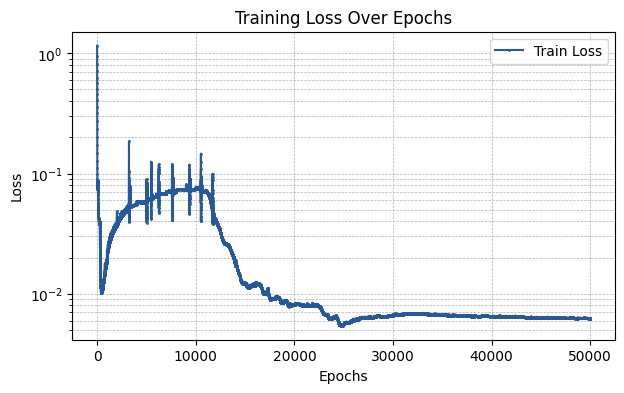

In [11]:
plt.figure(figsize=(7, 4))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='#25599c', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

Additionally, we observe a good approximation to the actual solution to the Allen-Cahn equation, which cannot be obtained without utilizing any adaptive technique.

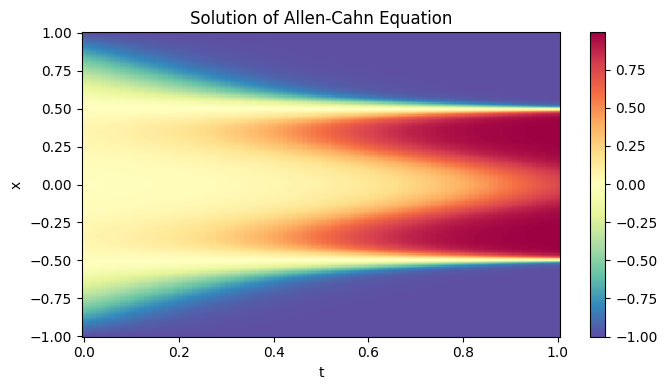

In [12]:
N_t, N_x = 100, 256

t = np.linspace(0.0, 1.0, N_t)
x = np.linspace(-1.0, 1.0, N_x)
T, X = np.meshgrid(t, x, indexing='ij')
coords = np.stack([T.flatten(), X.flatten()], axis=1)

output = model(jnp.array(coords))
resplot = np.array(output).reshape(N_t, N_x)

plt.figure(figsize=(7, 4))
plt.pcolormesh(T, X, resplot, shading='auto', cmap='Spectral_r')
plt.colorbar()

plt.title('Solution of Allen-Cahn Equation')
plt.xlabel('t')

plt.ylabel('x')

plt.tight_layout()
plt.show()